# **Прогностическая модель рисков беременных**

**Задача:**
- Создать модель МО, которая выявляет риски у беременных.

**Цель:**
- Достичь результата, позволяющего с высокой точностью выявлять пациентов с высоким уровнем риска осложнений.

**Условия:**
- Метрика и константные значения выбираются по своему усмотрению.

**Описание данных:**
- Датасет с медицинскими данными о пациенте:
    - возраст, систолическое и диастолическое АД, уровень глюкозы в крови, температура тела в фаренгейтах, частота сердечных сокращений, уровень риска (целевая переменная).

**План работы:**
1. Загрузка и первичное ознакомление с данными;
2. Предобработка данных;
3. Анализ данных;
4. Корреляционный анализ;
5. Подготовка данных к обучению;
6. Обучение моделей: SVC, KNeighbors, DecisionTree, LightGBM (с и без весов классов и подбором порога классификации);
7. Выбор лучшей модели;
8. Проверка на test;
9. Вывод.


---



---



***Импорт библиотек***

In [ ]:
pip install phik optuna catboost lightgbm optuna-integration[sklearn] -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings

# Подготовка данных
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Бустинги
import catboost, lightgbm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Перебор гиперпараметров
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV

# Метрики
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# Константы
RANDOM_STATE = 42

# Загрузка данных

**Загрузка данных**

In [ ]:
data = pd.read_csv("test_2.csv")
display(data.head(1))
data.info()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


____________
Признаки:

0. Возраст
1. Систолическое АД: верхнее значение артериального давления в мм рт.ст.
2. Диастолическое АД: Более низкое значение артериального давления в мм рт.ст
3. Уровень глюкозы в крови
4. Температура тела в фаренгейтах
5. Частота сердечных сокращений: нормальная частота сердечных сокращений в состоянии покоя в ударах в минуту.
6. Уровень риска (таргет)
______________

1014 строк, 7 столбцов, пропусков нет.

Целевая переменная - obj, уровень глюкозы и температура тела - float, остальные признаки имеют тип int.

# Предобработка

**Пропуски**

In [ ]:
print ('Пропусков в датасете:', data.isna().sum().sum())

Пропусков в датасете: 0


**Дубликаты**

In [ ]:
print ('Дубликатов, шт:', data.duplicated().sum())
display(data.loc[data.duplicated()==True].head(10))

print ('\nСоотношение классов таргета: \n\n')
print ('Дубликаты:\n', round(data.loc[data.duplicated()==True]['RiskLevel'].value_counts(normalize=True), 2))
print ('\nВесь датасет:\n', round(data['RiskLevel'].value_counts(normalize=True), 2))
print ('\nНе дубликаты:\n', round(data.loc[data.duplicated()==False]['RiskLevel'].value_counts(normalize=True), 2))

Дубликатов, шт: 562


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
67,19,120,80,7.0,98.0,70,mid risk
72,19,120,80,7.0,98.0,70,mid risk
97,19,120,80,7.0,98.0,70,mid risk
106,50,140,90,15.0,98.0,90,high risk
107,25,140,100,6.8,98.0,80,high risk
118,32,140,100,7.9,98.0,78,high risk
119,30,140,100,15.0,98.0,70,high risk
129,48,120,80,11.0,98.0,88,high risk
130,40,160,100,19.0,98.0,77,high risk
131,32,140,90,18.0,98.0,88,high risk



Соотношение классов таргета: 


Дубликаты:
 RiskLevel
mid risk     0.41
low risk     0.31
high risk    0.28
Name: proportion, dtype: float64

Весь датасет:
 RiskLevel
low risk     0.40
mid risk     0.33
high risk    0.27
Name: proportion, dtype: float64

Не дубликаты:
 RiskLevel
low risk     0.52
high risk    0.25
mid risk     0.23
Name: proportion, dtype: float64


- Данные, скорее всего, синтетические. Возможно, дубликаты были добавлены для увеличения доли строк с низким и высоким риском.
- Оставим их.

# Анализ данных

**Распределения:**

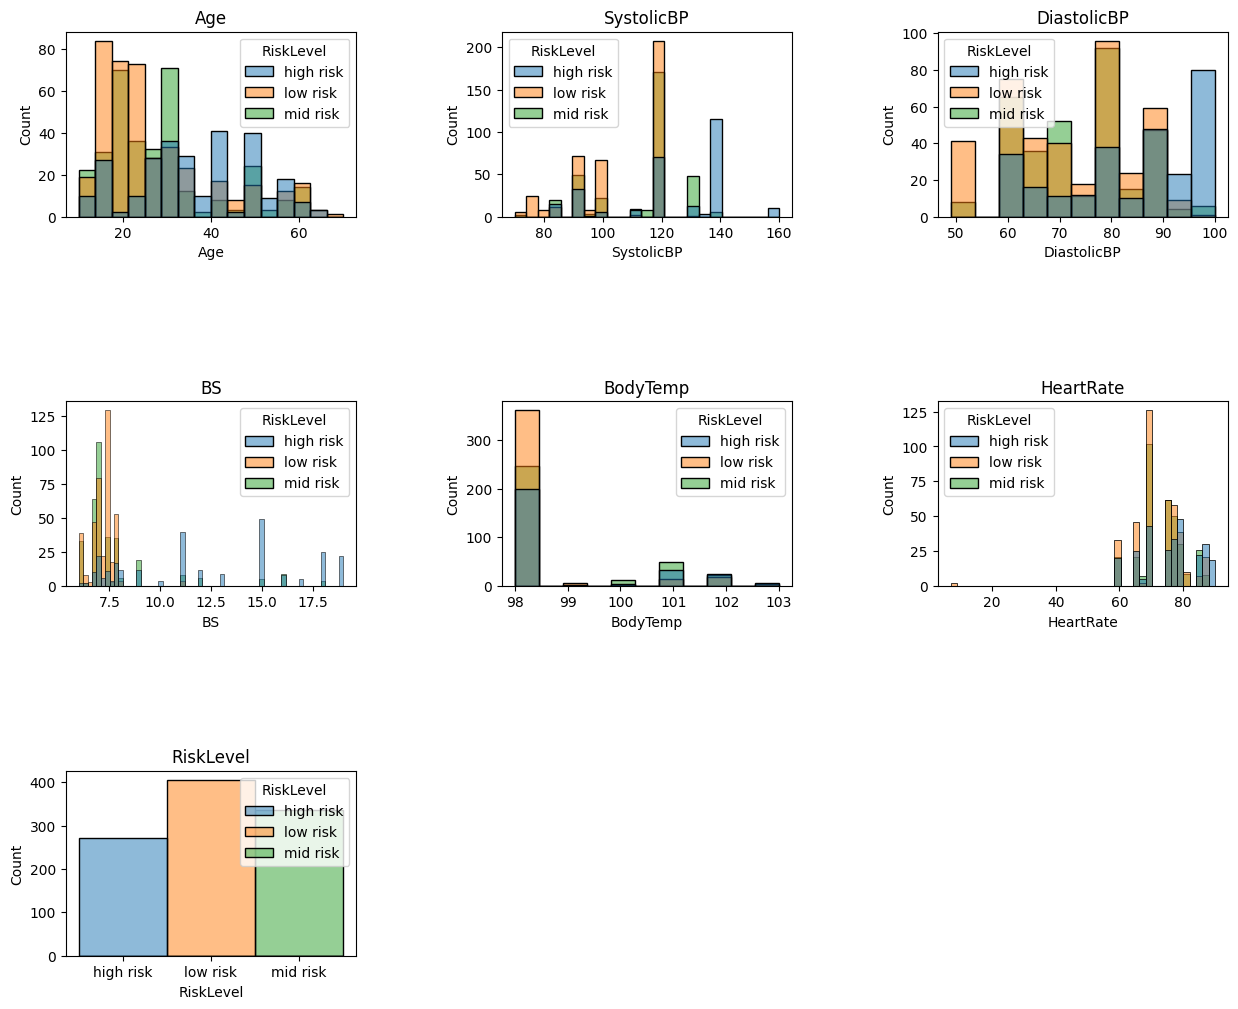

Описательная статистика


,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0


,count,mean,std,min,25%,50%,75%,max
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0


,count,mean,std,min,25%,50%,75%,max
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0


,count,mean,std,min,25%,50%,75%,max
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0


,count,mean,std,min,25%,50%,75%,max
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0


,count,mean,std,min,25%,50%,75%,max
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


,count,unique,top,freq
RiskLevel,1014,3,low risk,406


In [ ]:
plt.figure(figsize=[15, 12])
p=1
for i in data.columns:
    plt.subplot(3, 3, p)
    sns.histplot(data=data, x=i, hue='RiskLevel')
    plt.title(i)
    p+=1
plt.subplots_adjust(hspace = 1, wspace=0.5)
plt.show()

print ('Описательная статистика')
for i in data.columns:
    display (pd.DataFrame(data[i].describe()).T)

____________
**Выбросы**

**HeartLevel**

Удалим строки с HeartLevel = 7 - скорее всего ошибка, т.к. остальные величины нормальные, всего две строки и полностью повторяют друг друга. Еще и риск указан как минимальный:

In [ ]:
display ('Строки с HeartLevel ниже 40 до удаления:', data.query('HeartRate<40'))
print ('Минимальный HeartLevel без учета выбросов: ', data.query('HeartRate!=7')['HeartRate'].min())
print ('\nОписательная статистика для HeartRate:\n', data['HeartRate'].describe())

# удаляем строки с HeartRate=7
data = data.query('HeartRate!=7')

'Строки с HeartLevel ниже 40 до удаления:'

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


Минимальный HeartLevel без учета выбросов:  60

Описательная статистика для HeartRate:
 count    1014.000000
mean       74.301775
std         8.088702
min         7.000000
25%        70.000000
50%        76.000000
75%        80.000000
max        90.000000
Name: HeartRate, dtype: float64


**Возраст**

Процент присутствия в датасете возрастов:

In [ ]:
print ('Менее 18 лет:')
display(data['Age'].value_counts(normalize=True).sort_index().round(3).head(7))

print ('\n10 наиболее больших возрастов:')
data['Age'].value_counts(normalize=True).sort_index().round(3).tail(10)

Менее 18 лет:


,proportion
Age,
10,0.004
12,0.035
13,0.012
14,0.003
15,0.059
16,0.014
17,0.062



10 наиболее больших возрастов:


,proportion
Age,
54,0.012
55,0.037
56,0.001
59,0.002
60,0.034
62,0.001
63,0.002
65,0.003
66,0.001


Слишком много строк для 12 и 15 лет - 9.5% датасета. Следует уменьшить их количество, например, удалив дубликаты.

Посмотрим, как распределены значения RiskLevel для возрастов 12 и 15 лет в дубликатах и не дубликатах:

In [ ]:
print ('12 лет:')
print('\nВсе строки:\n', data.loc[data['Age']==12]['RiskLevel'].value_counts(normalize=True).round(2))
print('\nБез дубликатов:\n', data.loc[(data['Age']==12) & (data.duplicated()==False)]['RiskLevel'].value_counts(normalize=True).round(2))

print ('______________\n15 лет:')
print('\nВсе строки:\n', data.loc[data['Age']==15]['RiskLevel'].value_counts(normalize=True).round(2))
print('\nБез дубликатов:\n', data.loc[(data['Age']==15) & (data.duplicated()==False)]['RiskLevel'].value_counts(normalize=True).round(2))

12 лет:

Все строки:
 RiskLevel
low risk     0.43
mid risk     0.37
high risk    0.20
Name: proportion, dtype: float64

Без дубликатов:
 RiskLevel
low risk     0.52
mid risk     0.29
high risk    0.19
Name: proportion, dtype: float64
______________
15 лет:

Все строки:
 RiskLevel
low risk    0.93
mid risk    0.07
Name: proportion, dtype: float64

Без дубликатов:
 RiskLevel
low risk    0.94
mid risk    0.06
Name: proportion, dtype: float64


______________
Удаление дубликатов для возраста 12 лет приведет к небольшому увеличению доли пациентов с низким риском в датасете.

При этом у пациентов возраста 15 лет вообще отсутствуют значения 'high risk'.
_______________

Уберем дубликаты для возраста 12 лет и 15 лет, т.к. 3,5% и 6% датасета соответственно для этих возрастов - кажется, слишком много.

In [ ]:
data = data.drop(data.loc[(data['Age']==12) & (data.duplicated()==True)].index)
data = data.drop(data.loc[(data['Age']==15) & (data.duplicated()==True)].index)

Доля 12 и 15 лет уменьшилась:

In [ ]:
data['Age'].value_counts(normalize=True).sort_index().round(3).head(7)

,proportion
Age,
10,0.004
12,0.022
13,0.012
14,0.003
15,0.032
16,0.014
17,0.065


_____________
**Распределение таргета**

In [ ]:
data['RiskLevel'].value_counts(normalize=True).round(2)

,proportion
RiskLevel,
low risk,0.38
mid risk,0.34
high risk,0.28


- Высокий риск - менее чем в 30% случаев.

_______
**Визуализируем зависимости**

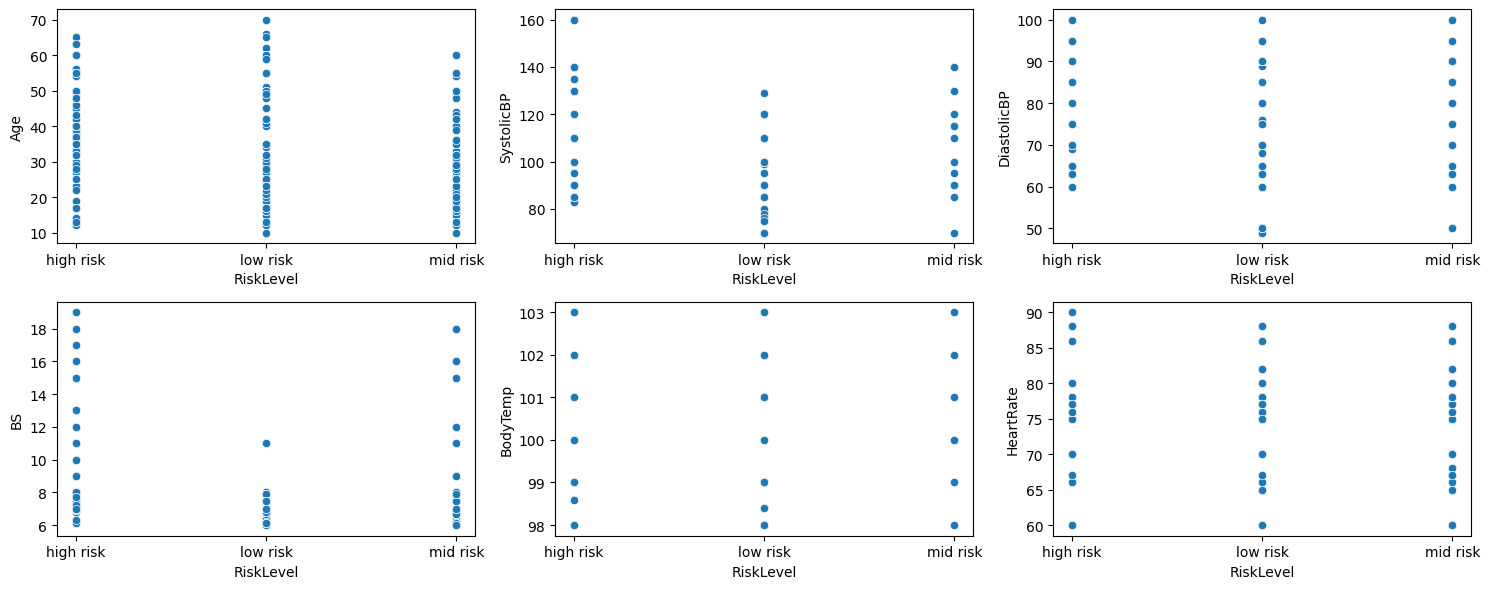

In [ ]:
p=1
plt.figure(figsize=(15, 6))
for i in data.drop('RiskLevel', axis=1).columns:
    plt.subplot(2, 3, p)
    sns.scatterplot(data = data, x='RiskLevel', y=i, palette='deep')
    plt.tight_layout()
    p+=1
plt.show()

- Повышенный риск связан с высоким верхним давлением и высоким уровнем глюкозы.
- BS можно попробовать перевести в категориальную величину (UPD. попробовал - корреляция с целевым признаком упала, метрика тоже, оставил как было)

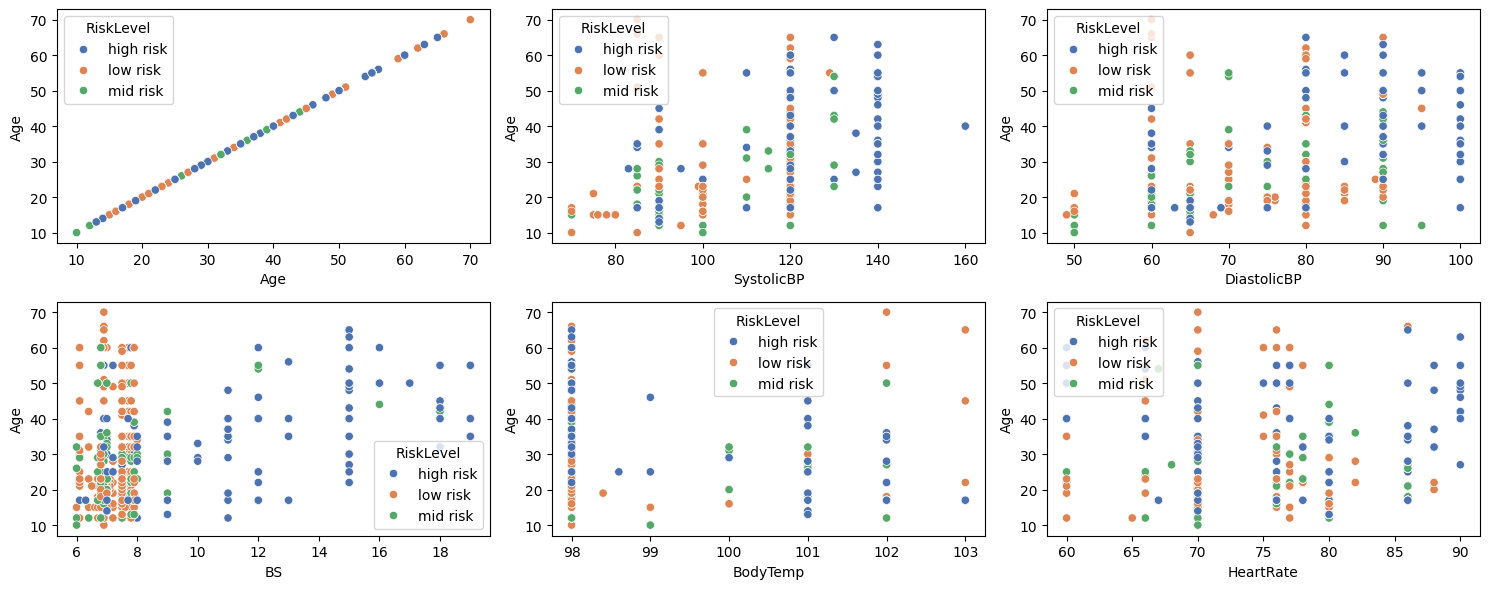

In [ ]:
p=1
plt.figure(figsize=(15, 6))
for i in data.drop('RiskLevel', axis=1).columns:
    plt.subplot(2, 3, p)
    sns.scatterplot(data = data, x=i, y='Age', hue='RiskLevel', palette='deep')
    plt.tight_layout()
    p+=1
plt.show()

Чаще всего высокий риск встречается среди пациентов:
- с повышенной глюкозой - BS - от 9-10 ммоль/л;
- с верхним давлением выше 130 - всегда высокий риск;
- с сердцебиением от 85 уд/мин и выше.

___________
**Корреляции**

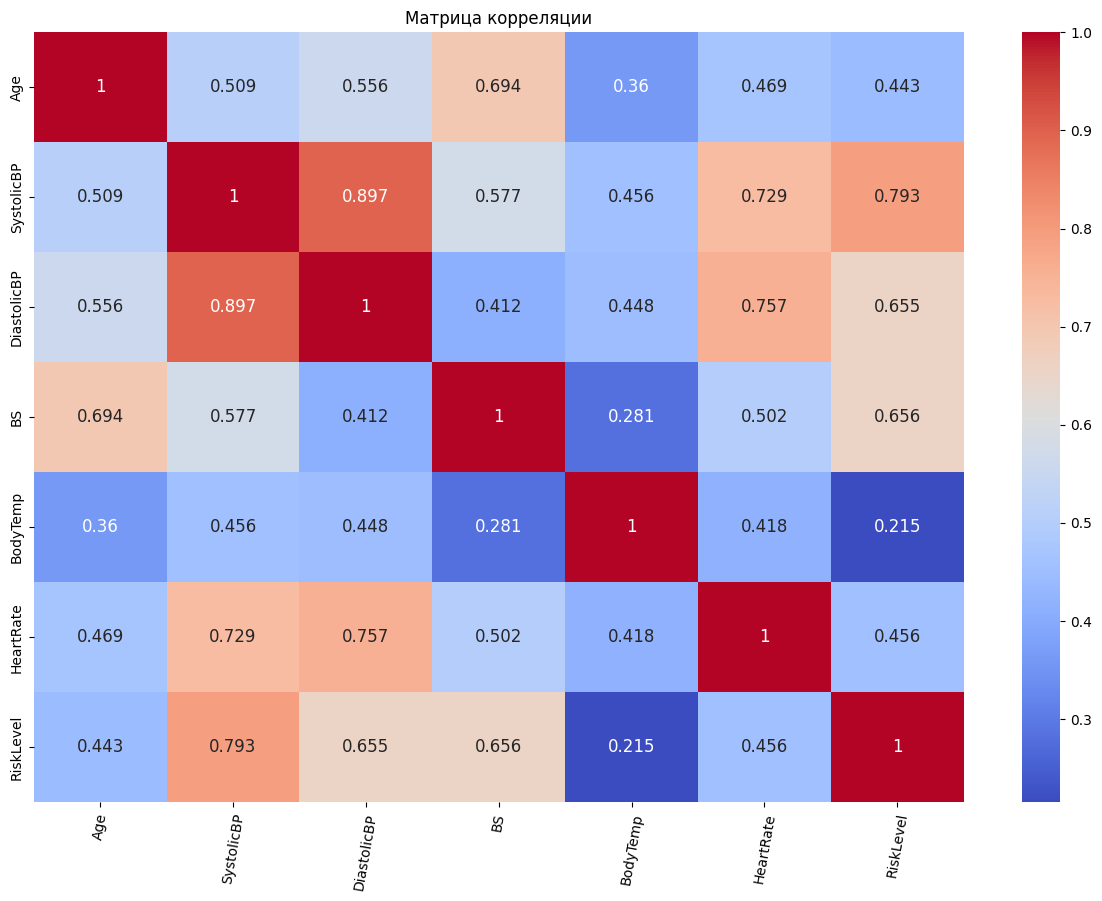

In [ ]:
interval_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

figsize = (7,7)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции')
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), ax=ax, annot=True, fmt='.3g', cmap='coolwarm', annot_kws={'size':12})
plt.xticks(rotation=80)
plt.show()

- Высокая корреляция между нижним и верхним давлением, что логично. Но оставим оба признака, т.к. клиническая картина у пациентов может быть разная, например, повышенное нижнее давление при нормальном верхнем.

# **Подготовка данных**

Входные признаки и таргет:

In [ ]:
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']

Формируем выборки:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

**Кодирование целевого признака:**
- 0 - низкий риск
- 1 - средний риск
- 2 - высокий риск

In [ ]:
# кодируем через OrdinalEncoder, чтобы соблюсти последовательность
target_encoder = OrdinalEncoder(categories=[['low risk', 'mid risk', 'high risk']], handle_unknown='use_encoded_value', unknown_value=np.nan)

y_train = target_encoder.fit_transform(y_train.to_frame()).astype('int')
y_test = target_encoder.transform(y_test.to_frame()).astype('int')
y_train[:5]

array([[0],
       [0],
       [1],
       [2],
       [0]])

**Масштабирование**

In [ ]:
scaler = StandardScaler()
columns = X_train.columns

# обучаем скейлер, масштабируем тестовую и тренировочную выборки
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Формируем датафреймы с масштабированными данными
X_train = pd.DataFrame(X_train_scaled, columns=columns)
X_test = pd.DataFrame(X_test_scaled, columns=columns)
X_train.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,-1.168462,-1.860406,-1.230225,-0.621674,-0.499003,0.699140
1,-0.790516,-0.759826,0.945384,-0.383562,-0.499003,1.743388
2,-1.319641,-1.310116,-0.867624,-0.264505,1.669563,0.699140
3,0.343321,-1.585261,-1.230225,0.658183,2.392418,1.482326
4,-1.017284,-1.310116,-1.230225,-0.383562,1.669563,0.177017


#  **Обучение моделей**

## SVC

In [ ]:
model = SVC(random_state=RANDOM_STATE, probability=True)

parameters = {'kernel': distributions.CategoricalDistribution(choices=('linear', 'rbf', 'poly')),
              'C': distributions.FloatDistribution(0.1, 100)}

svc_cv = OptunaSearchCV(model,
                        parameters,
                        cv=5,
                        n_trials=50,
                        scoring='f1_macro',
                        random_state=RANDOM_STATE)

svc_cv.fit(X_train, y_train)

[I 2025-04-27 03:23:53,118] A new study created in memory with name: no-name-2b8a1814-53d5-439b-88ec-02befa427dd0
[I 2025-04-27 03:23:54,259] Trial 0 finished with value: 0.6880320074759508 and parameters: {'kernel': 'rbf', 'C': 32.01278037887276}. Best is trial 0 with value: 0.6880320074759508.
[I 2025-04-27 03:23:58,228] Trial 1 finished with value: 0.6243354434553872 and parameters: {'kernel': 'linear', 'C': 16.758009113183828}. Best is trial 0 with value: 0.6880320074759508.
[I 2025-04-27 03:24:04,810] Trial 2 finished with value: 0.6767328924717093 and parameters: {'kernel': 'poly', 'C': 99.92516094797547}. Best is trial 0 with value: 0.6880320074759508.
[I 2025-04-27 03:24:08,079] Trial 3 finished with value: 0.6243354434553872 and parameters: {'kernel': 'linear', 'C': 47.326439900025996}. Best is trial 0 with value: 0.6880320074759508.
[I 2025-04-27 03:24:08,650] Trial 4 finished with value: 0.7265524169837104 and parameters: {'kernel': 'rbf', 'C': 95.24276997680995}. Best is tr

OptunaSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=1,
               n_trials=50,
               param_distributions={'C': FloatDistribution(high=100.0, log=False, low=0.1, step=None),
                                    'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly'))},
               random_state=42, scoring='f1_macro')

In [ ]:
# Лучший результат
svc_cv.best_score_

0.7277014440224918

## KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier()

parameters = {'n_neighbors': distributions.IntDistribution(1, 300)}

neighbors_cv = OptunaSearchCV(model,
                        parameters,
                        cv=5,
                        n_trials=30,
                        scoring='f1_macro',
                        random_state=RANDOM_STATE)

neighbors_cv.fit(X_train, y_train)

[I 2025-04-27 03:25:04,187] A new study created in memory with name: no-name-08ff79af-2609-477b-a63e-e3a6249173ef
[I 2025-04-27 03:25:04,317] Trial 0 finished with value: 0.5353069247619617 and parameters: {'n_neighbors': 137}. Best is trial 0 with value: 0.5353069247619617.
[I 2025-04-27 03:25:04,441] Trial 1 finished with value: 0.46260311359751655 and parameters: {'n_neighbors': 250}. Best is trial 0 with value: 0.5353069247619617.
[I 2025-04-27 03:25:04,556] Trial 2 finished with value: 0.6626480258816363 and parameters: {'n_neighbors': 21}. Best is trial 2 with value: 0.6626480258816363.
[I 2025-04-27 03:25:04,667] Trial 3 finished with value: 0.5880401600133085 and parameters: {'n_neighbors': 96}. Best is trial 2 with value: 0.6626480258816363.
[I 2025-04-27 03:25:04,797] Trial 4 finished with value: 0.5206605235502877 and parameters: {'n_neighbors': 146}. Best is trial 2 with value: 0.6626480258816363.
[I 2025-04-27 03:25:04,952] Trial 5 finished with value: 0.5916874661152687 a

OptunaSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1, n_trials=30,
               param_distributions={'n_neighbors': IntDistribution(high=300, log=False, low=1, step=1)},
               random_state=42, scoring='f1_macro')

In [ ]:
# Лучший результат
neighbors_cv.best_score_

0.7969722686151454

## DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

parameters = {'min_samples_split': distributions.IntDistribution(2, 15),
              'min_samples_leaf': distributions.IntDistribution(1, 15),
             'max_features': distributions.IntDistribution(1, 10)}

decision_tree_cv = OptunaSearchCV(model, parameters, cv=3, n_trials=30, scoring='f1_macro', random_state=RANDOM_STATE)

decision_tree_cv.fit(X_train, y_train)

[I 2025-04-27 03:25:08,352] A new study created in memory with name: no-name-65d99c87-edc3-42e8-8499-8bf260fce6d6
[I 2025-04-27 03:25:08,377] Trial 0 finished with value: 0.33412058333951883 and parameters: {'min_samples_split': 8, 'min_samples_leaf': 13, 'max_features': 1}. Best is trial 0 with value: 0.33412058333951883.
[I 2025-04-27 03:25:08,403] Trial 1 finished with value: 0.659328839514347 and parameters: {'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 3}. Best is trial 1 with value: 0.659328839514347.
[I 2025-04-27 03:25:08,429] Trial 2 finished with value: 0.7119424891329341 and parameters: {'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 2}. Best is trial 2 with value: 0.7119424891329341.
[I 2025-04-27 03:25:08,456] Trial 3 finished with value: 0.6945541929210696 and parameters: {'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 10}. Best is trial 2 with value: 0.7119424891329341.
[I 2025-04-27 03:25:08,482] Trial 4 finished with va

OptunaSearchCV(cv=3,
               estimator=DecisionTreeClassifier(class_weight='balanced',
                                                random_state=42),
               n_jobs=1, n_trials=30,
               param_distributions={'max_features': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_samples_leaf': IntDistribution(high=15, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=15, log=False, low=2, step=1)},
               random_state=42, scoring='f1_macro')

In [ ]:
# Лучший результат
decision_tree_cv.best_score_

0.7705565950318789

## LightGBM

Сделаем две модели: с указанием весов для классов и без

### **1. С весами классов.**   
Наиболее критично для работы определение всех случаев с повышенным риском для беременных, для этого надо максимально поднять recall класса 2 (high risk)

In [ ]:
model = LGBMClassifier(objective='multiclass', class_weight={0: 1, 1: 1, 2: 10}, random_state=RANDOM_STATE, n_jobs=-1, metric='multi_logloss', verbosity= -1)

# Параметры, которые будем перебирать
parameters = {'n_estimators': optuna.distributions.IntDistribution(1, 1000),
              'subsample_for_bin ': distributions.IntDistribution(1, 50),
              'reg_lambda': distributions.IntDistribution(0, 10),
              'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.5),
              'max_depth': distributions.IntDistribution(1, 100),
              'num_leaves': distributions.IntDistribution(1, 100)}

# Перебор через Оптуну с метрикой f1
lgbm_cv_1 = OptunaSearchCV(model,
                         parameters,
                         scoring='f1_macro',
                         cv=5,
                         n_trials=30,
                         random_state=RANDOM_STATE)

lgbm_cv_1.fit(X_train, y_train)
lgbm_cv_1.best_score_

[I 2025-04-27 03:25:09,572] A new study created in memory with name: no-name-b7d1598e-ba81-4a1f-8ab0-729520ea464f
[I 2025-04-27 03:25:11,697] Trial 0 finished with value: 0.8242071556760836 and parameters: {'n_estimators': 455, 'subsample_for_bin ': 42, 'reg_lambda': 0, 'learning_rate': 0.166529153009486, 'max_depth': 49, 'num_leaves': 30}. Best is trial 0 with value: 0.8242071556760836.
[I 2025-04-27 03:25:12,771] Trial 1 finished with value: 0.8207560180997342 and parameters: {'n_estimators': 213, 'subsample_for_bin ': 9, 'reg_lambda': 1, 'learning_rate': 0.1660871691787492, 'max_depth': 35, 'num_leaves': 100}. Best is trial 0 with value: 0.8242071556760836.
[I 2025-04-27 03:25:15,064] Trial 2 finished with value: 0.819308074841366 and parameters: {'n_estimators': 507, 'subsample_for_bin ': 12, 'reg_lambda': 4, 'learning_rate': 0.2416411967068342, 'max_depth': 86, 'num_leaves': 98}. Best is trial 0 with value: 0.8242071556760836.
[I 2025-04-27 03:25:16,555] Trial 3 finished with valu

0.8258363131366988

In [ ]:
# Значение метрики лучшей модели
lgbm_metric_1 = lgbm_cv_1.best_score_
print ('f1_macro = ', round(lgbm_metric_1, 3))

f1_macro =  0.826


###  **2. Без весов классов.**  
Пусть модель обучится максимально эффективно для всех классов. Проблему критичности 2 класса можно будет решить потом, через порог классификации, если в матрице ошибок будет много объектов 3 класса, ошибочно отнесенных к 1 или 2.

In [ ]:
model = LGBMClassifier(objective='multiclass', random_state=RANDOM_STATE, n_jobs=-1, metric='multi_logloss', verbosity= -1)

# Параметры, которые будем перебирать
parameters = {'n_estimators': optuna.distributions.IntDistribution(1, 1500),
              'reg_lambda': distributions.FloatDistribution(0, 2),
              'learning_rate': optuna.distributions.FloatDistribution(0.01, 1),
              'max_depth': distributions.IntDistribution(1, 200),
              'num_leaves': distributions.IntDistribution(1, 200)}

# Перебор через Оптуну с метрикой f1
lgbm_cv_2 = OptunaSearchCV(model,
                         parameters,
                         scoring='f1_macro',
                         cv=5,
                         n_trials=30,
                         random_state=RANDOM_STATE)

lgbm_cv_2.fit(X_train, y_train)
lgbm_cv_2.best_score_

[I 2025-04-27 03:26:05,552] A new study created in memory with name: no-name-12d854df-dd11-4144-b45d-bf7addff2674
[I 2025-04-27 03:26:08,912] Trial 0 finished with value: 0.8299890485592666 and parameters: {'n_estimators': 683, 'reg_lambda': 1.6652640646299195, 'learning_rate': 0.07836082746486815, 'max_depth': 64, 'num_leaves': 98}. Best is trial 0 with value: 0.8299890485592666.
[I 2025-04-27 03:26:12,751] Trial 1 finished with value: 0.8312256058949485 and parameters: {'n_estimators': 448, 'reg_lambda': 0.42485254798444516, 'learning_rate': 0.17507936959010997, 'max_depth': 36, 'num_leaves': 64}. Best is trial 1 with value: 0.8312256058949485.
[I 2025-04-27 03:26:14,936] Trial 2 finished with value: 0.8324519408172533 and parameters: {'n_estimators': 524, 'reg_lambda': 1.9985017206801896, 'learning_rate': 0.5116177680816173, 'max_depth': 48, 'num_leaves': 78}. Best is trial 2 with value: 0.8324519408172533.
[I 2025-04-27 03:26:17,779] Trial 3 finished with value: 0.8361872499763461 

0.8392148244411175

In [ ]:
# Значение метрики лучшей модели
lgbm_metric_2 = lgbm_cv_2.best_score_
print ('f1_macro = ', round(lgbm_metric_2, 3))

f1_macro =  0.839


#### **Подбор порога классификации для 2 класса**

Сначала выведем матрицу ошибок и посмотрим, как модель справляется с определением 2 класса (высокий риск).

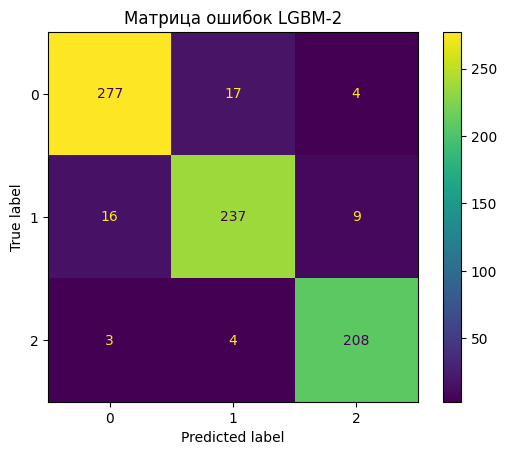

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, lgbm_cv_2.predict(X_train))
plt.title('Матрица ошибок LGBM-2')
plt.show()

Формируем таблицу с результатами предсказаний класса и предсказаний вероятностей классов для train:

In [ ]:
# Вероятности
probas = lgbm_cv_2.predict_proba(X_train)
# Таблица с предсказанными классами для объектов
lgbm_2_predicted = pd.DataFrame(lgbm_cv_2.predict(X_train).tolist())
# Добавляем вероятности для 2 класса
lgbm_2_predicted['probas_of_2']=probas[:, 2]
display(lgbm_2_predicted.head())

,0,probas_of_2
0,0,0.000139
1,0,0.000224
2,1,0.002056
3,2,0.999064
4,0,0.001245


Назначим порог классификации 0.1 и посмотрим, как изменятся результаты матрицы ошибок:

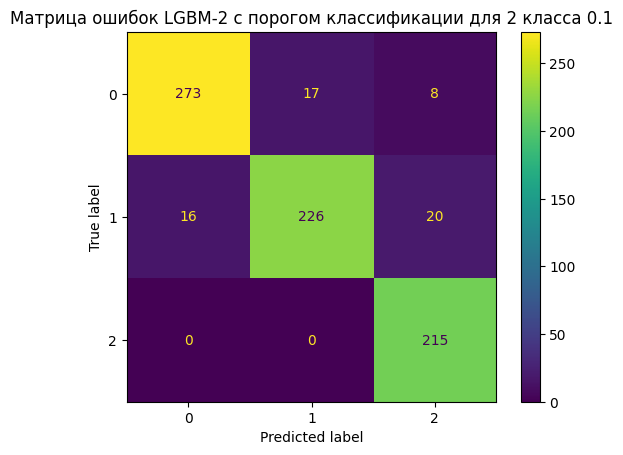

f1: 0.921


In [ ]:
# Присваиваем класс 2 всем объектам, с вероятностью второго класса выше 0.2
lgbm_2_predicted.loc[lgbm_2_predicted['probas_of_2']>=0.1] = 2

ConfusionMatrixDisplay.from_predictions(y_train, lgbm_2_predicted[0])
plt.title('Матрица ошибок LGBM-2 с порогом классификации для 2 класса 0.1')
plt.show()

print ('f1:', round(f1_score(y_train, lgbm_2_predicted[0], average='macro'), 3))

- улучшен recall для 2 класса (100%).

# Выбор модели

Сравним метрики разных моделей и посмотрим матрицы ошибок на train:

  f1_macro score:
0.728 - SVC
0.797 - KNeighbors
0.771 - DecisionTree
0.826 - LGBM-1
0.839 - LGBM-2


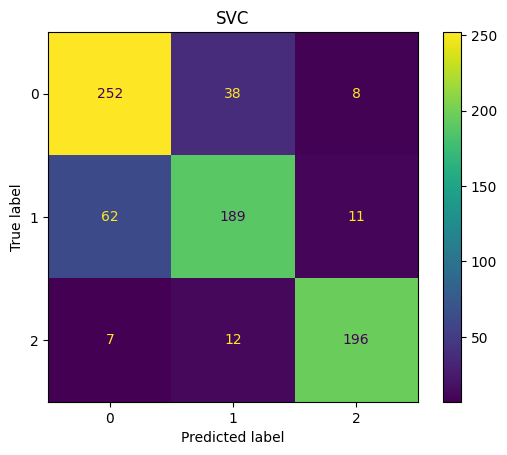

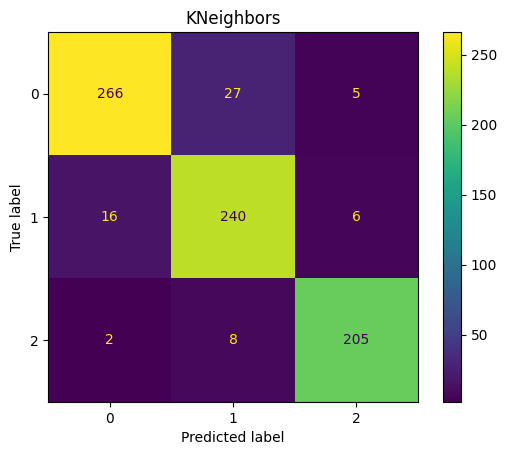

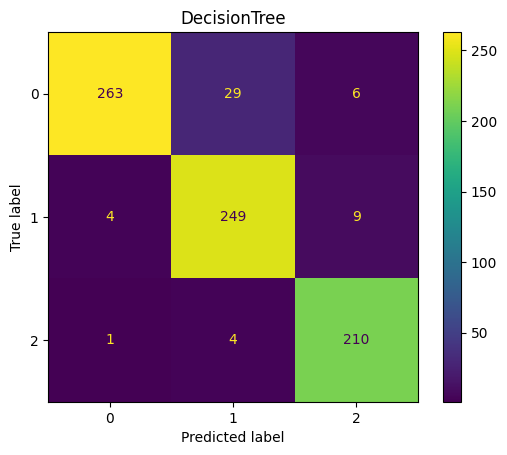

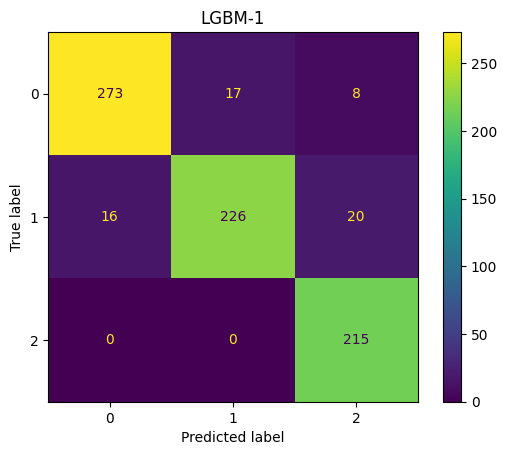

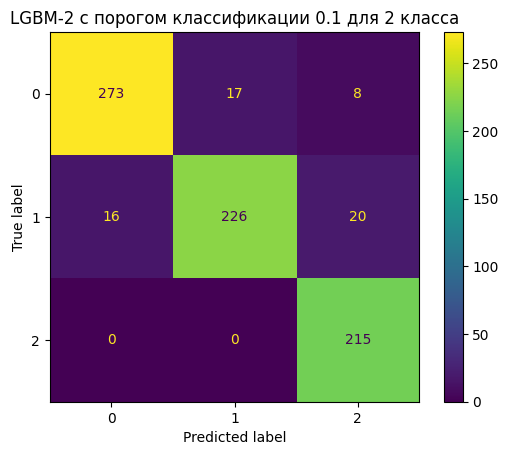

In [ ]:
names = ['SVC', 'KNeighbors', 'DecisionTree', 'LGBM-1', 'LGBM-2']
p = 0
print ('  f1_macro score:')
for i in [svc_cv, neighbors_cv, decision_tree_cv, lgbm_cv_1, lgbm_cv_2]:
  print(f'{round(i.best_score_, 3)} - {names[p]}')
  p+=1

p=0
for i in [svc_cv, neighbors_cv, decision_tree_cv, lgbm_cv_1]:
  ConfusionMatrixDisplay.from_predictions(y_train, i.predict(X_train))
  plt.title(f'{names[p]}')
  plt.show()
  p+=1

ConfusionMatrixDisplay.from_predictions(y_train, lgbm_2_predicted[0])
plt.title('LGBM-2 с порогом классификации 0.1 для 2 класса')
plt.show()

**Решение:**

Выбираем модель LGBM-2 (без весов классов) с пороговым значением классификации 0.2 для 2 класса (высокий риск) как лучшую по совокупности метрика - матрица ошибок.

# **Проверка на test**

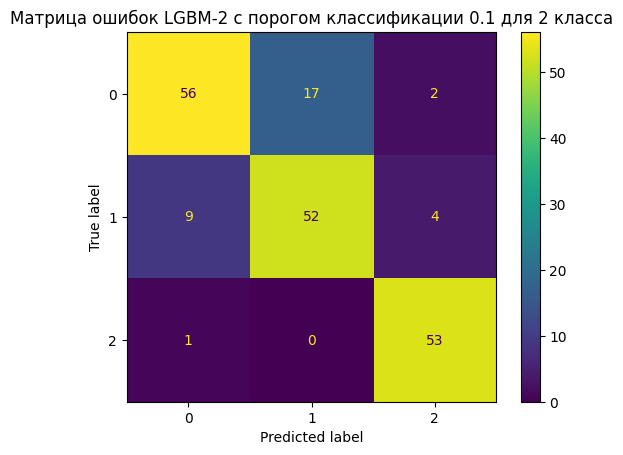

f1 macro =  0.836
Accuracy =  0.83


In [ ]:
# Вероятности
probas_test = lgbm_cv_2.predict_proba(X_test)

# Таблица с предсказанными классами для объектов
lgbm_2_predicted_test = pd.DataFrame(lgbm_cv_2.predict(X_test).tolist())

# Добавляем вероятности для 2 класса
lgbm_2_predicted_test['probas_of_2']=probas_test[:, 2]

# Присваиваем класс 2 всем объектам, с вероятностью второго класса выше 0.2
lgbm_2_predicted_test.loc[lgbm_2_predicted_test['probas_of_2']>=0.1] = 2

# Выводим матрицу ошибок
ConfusionMatrixDisplay.from_predictions(y_test, lgbm_2_predicted_test[0])
plt.title('Матрица ошибок LGBM-2 с порогом классификации 0.1 для 2 класса')
plt.show()

# Выводим метрику
print ('f1 macro = ', round(f1_score(y_test, lgbm_2_predicted_test[0], average='macro'), 3))
print ('Accuracy = ', round(accuracy_score(y_test, lgbm_2_predicted_test[0]), 3))

**Результат:**

Метрика f1 на тесте 0.836, неплохой результат.

С классом 2 (высокий риск) модель с установленным порогом справляется хорошо:
- Найдены 53 из 54 пациентов с высоким риском, при этом единственный неверно классифицированный отнесен к классу 0 (низкий риск)
- 6 пациента с низким  и средним риском ошибочно классифицированны как пациенты с высоким риском
- Recall = 0.98, Precision = 0.9

Самый низкий recall у класса 0:
- Из 75 таких пациентов верно классифицированны только 56. 17 отнесены к 1 классу, 2 - ко 2, высокого риска
- Recall = 0.75, Precision = 0.85

Класс 1:
- Верно классифицированы 52 из 65 таких пациентов. 9 отнесены моделью к 0 классу, еще 4 - ко 2.
- Recall = 0.8, Precision = 0.75

# **Вывод**

Построена модель:
- LGBMClassifier(learning_rate=0.7574833311906105, max_depth=160, metric='multi_logloss', n_estimators=167, n_jobs=-1, num_leaves=118, objective='multiclass', random_state=42, reg_lambda=0.7732084411096949, verbosity=-1)

Установлен следующий порог классификации:
- 0.1 для класса 2 (high risk)

Результаты на test:
- f1_macro = 0.836
- Accuracy = 0.83
- 0 класс: Recall = 0.75, Precision = 0.85
- 1 класс: Recall = 0.8, Precision = 0.75
- 2 класс: Recall = 0.98, Precision = 0.9

Поскольку наиболее критичной задачей мы считаем выявление пациентов с высоким риском, небольшой перекос в качестве работы модели в сторону 2 класса в данном случае оправдан.
________________
Ниже выведены матрицы ошибок и метрики.

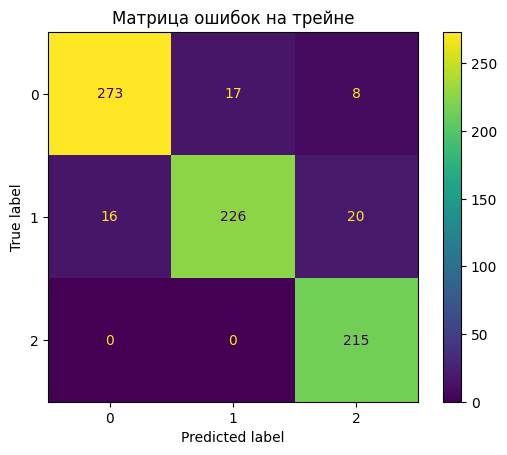

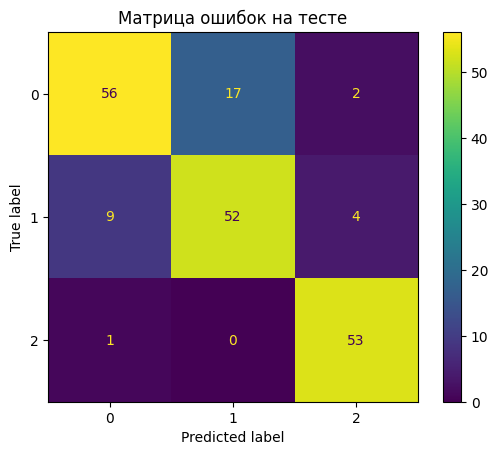

0.839  - f1 macro на кросс-валидации
0.921  - f1 macro на трейне с порогом 0.1
0.836  - f1 macro на тесте


In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, lgbm_2_predicted[0])
plt.title('Матрица ошибок на трейне')
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, lgbm_2_predicted_test[0])
plt.title('Матрица ошибок на тесте')
plt.show()

print (round(lgbm_metric_2, 3), ' - f1 macro на кросс-валидации')
print (round(f1_score(y_train, lgbm_2_predicted[0], average='macro'), 3), ' - f1 macro на трейне с порогом 0.1')
print (round(f1_score(y_test, lgbm_2_predicted_test[0], average='macro'), 3), ' - f1 macro на тесте')